## Uncertainty Aware Remaining Useful Life (RUL) Estimation with Bayesian LSTM

### 0. Imports & Configuration

- We utilize **TensorFlow/Keras** for constructing the deep learning architecture, with standard scientific Python libraries for data handling and visualization.  
- A fixed **random seed (ME 405)** is applied to ensure **reproducibility** across weight initializations and dropout realizations.
- The most critical configuration parameter is the **sequence length**, which defines the temporal window size for the LSTM. Each input sample consists of the previous **30 operational cycles**, enabling the model to capture trends rather than instantaneous sensor values.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# seed for reproducibility
np.random.seed(405)
tf.random.set_seed(405)

# Load Processed Data
data_dir = '../data/processed'
train_df = pd.read_csv(f'{data_dir}/train_featured.csv')
val_df = pd.read_csv(f'{data_dir}/val_featured.csv')
test_df = pd.read_csv(f'{data_dir}/test_featured.csv')

# Config
SEQUENCE_LENGTH = 30 
BATCH_SIZE = 128
EPOCHS = 25

### 1. Determine Optimal RUL Threshold
Instead of arbitrarily choosing a threshold, we analyze the correlation between sensor values and RUL at different clipping limits. Ideally, we want a threshold where the sensor signal starts to show a strong negative correlation with the degrading RUL.
- Observation: While the pure statistical correlation peaks around 95 cycles, restricting the model to such a short horizon limits the predictive utility for maintenance planning.
- Decision: We select a threshold of 125 cycles. This is a standard value in the literature (Heimes et al.) that provides a balanced trade off: it offers a longer lead time for the RL agent to act, while maintaining a sufficiently high signal to noise ratio for the LSTM to learn effectively.

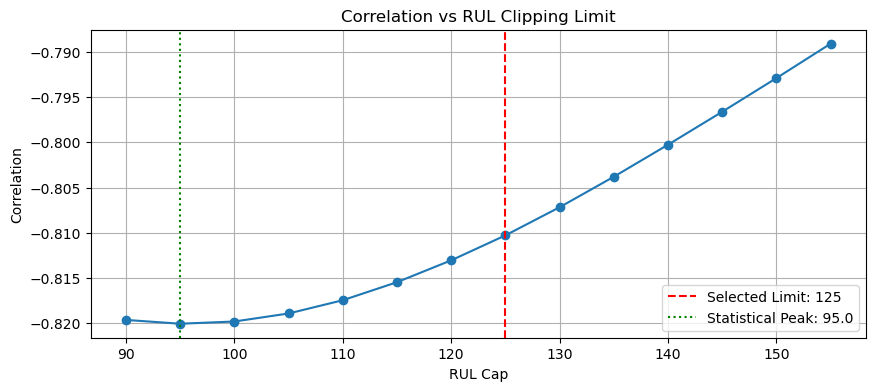

In [2]:
def find_optimal_rul_limit(df, sensor_col='s_11_mean', threshold=-0.5):

    results = []
    # Test potential limits from 90 to 160
    for limit in range(90, 160, 5):
        temp_rul = df['RUL'].clip(upper=limit)
        corr = df[[sensor_col]].corrwith(temp_rul).values[0]
        results.append((limit, corr))
        
    results_df = pd.DataFrame(results, columns=['Limit', 'Correlation'])
    
    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(results_df['Limit'], results_df['Correlation'], marker='o')
    plt.axvline(x=125, color='r', linestyle='--', label='Selected Limit: 125')
    
    # Mathematical Optimal
    math_best = results_df.loc[results_df['Correlation'].idxmin()]['Limit']
    plt.axvline(x=math_best, color='g', linestyle=':', label=f'Statistical Peak: {math_best}')
    
    plt.title('Correlation vs RUL Clipping Limit')
    plt.xlabel('RUL Cap')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return math_best

target_sensor = 's_11_mean' if 's_11_mean' in train_df.columns else 's_11'
stats_best = find_optimal_rul_limit(train_df, sensor_col=target_sensor)

# FORCE THE LITERATURE STANDARD
RUL_CAP = 125.0

### 2. Piecewise Linear RUL Strategy

A fundamental characteristic of the C-MAPSS dataset is the initial **healthy phase** of engine operation. During the early lifecycle (approximately the first 50–100 cycles), physical degradation occurs but is **not observable in sensor readings**, resulting in nearly constant inputs while the ground truth RUL decreases linearly.

- Training directly on the raw RUL signal introduces a **conflicting learning signal**, where identical inputs correspond to different targets. This often leads to **poor convergence or model collapse**.
- To resolve this issue, we apply the **Piecewise Linear RUL strategy** proposed by Heimes et al. (2008), where the RUL is **clipped at a predefined threshold**:
$$\mathrm{RUL}_{\mathrm{clipped}} = \min(\mathrm{RUL}, 125)$$
- This formulation assumes the engine remains in a nominal healthy state until degradation becomes observable.  
Additionally, the clipped RUL is **normalized to the range $[0,1]$** to improve numerical stability and accelerate gradient based optimization.


In [3]:
# features
drop_cols = ['unit_number', 'time_cycles', 'RUL', 'setting_1', 'setting_2', 'setting_3']
feature_cols = [c for c in train_df.columns if c not in drop_cols]

def process_targets(df):
    # Clip RUL at 125
    df['RUL_clipped'] = df['RUL'].clip(upper=RUL_CAP)
    df['RUL_scaled'] = df['RUL_clipped'] / RUL_CAP
    return df

train_df = process_targets(train_df)
val_df = process_targets(val_df)
test_df = process_targets(test_df)

### 3. Temporal Windowing (Sequence Generation)

LSTM network input data in a **3D tensor format**:
$$(\text{Samples}, \text{Time Steps}, \text{Features})$$

Rather than reshaping the dataset arbitrarily, we implement a **sliding window approach** that preserves temporal ordering. For each engine unit:

- **Input $(X)$** consists of a matrix of shape $(30, N_{\mathrm{features}})$, representing the most recent operational history.
- **Target $(y)$** corresponds to the **scaled RUL value** at the final time step of the window.

Each engine unit is processed **independently** to prevent data leakage across different lifecycles, ensuring that failure information from one engine does not contaminate another.


In [4]:
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# 3D Sequences
X_train_seq, y_train_seq = [], []

# Train Loop
for unit in train_df['unit_number'].unique():
    df_unit = train_df[train_df['unit_number'] == unit]
    if len(df_unit) > SEQUENCE_LENGTH:
        for seq in gen_sequence(df_unit, SEQUENCE_LENGTH, feature_cols):
            X_train_seq.append(seq)
        # predict the SCALED RUL
        for label in gen_labels(df_unit, SEQUENCE_LENGTH, ['RUL_scaled']):
            y_train_seq.append(label)

# Validation Loop
X_val_seq, y_val_seq = [], []
for unit in val_df['unit_number'].unique():
    df_unit = val_df[val_df['unit_number'] == unit]
    if len(df_unit) > SEQUENCE_LENGTH:
        for seq in gen_sequence(df_unit, SEQUENCE_LENGTH, feature_cols):
            X_val_seq.append(seq)
        for label in gen_labels(df_unit, SEQUENCE_LENGTH, ['RUL_scaled']):
            y_val_seq.append(label)

X_train = np.array(X_train_seq)
y_train = np.array(y_train_seq)
X_val = np.array(X_val_seq)
y_val = np.array(y_val_seq)

### 4. Bayesian LSTM with Monte Carlo Dropout

To adress predictive uncertainty, we apply **Monte Carlo Dropout** as an approximation to Bayesian inference, following Gal & Ghahramani (2016). In standard neural networks, dropout is used only during training as a regularization mechanism. Here, dropout layers are explicitly forced to remain active during inference by setting `training=True`. As a result:
- Each forward pass samples a **different sub network**
- Repeated evaluations generate a **distribution of predictions** instead of a single point estimate

From this distribution, we extract:
- **Predictive Mean**: the expected RUL estimate
- **Predictive Standard Deviation**: the model’s **uncertainty**, reflecting lack of confidence due to limited data

In [5]:
def create_mc_lstm(input_shape):
    inputs = Input(shape=input_shape)
    
    # LSTM Layers with MC Dropout enabled
    x = LSTM(100, return_sequences=True)(inputs)
    x = Dropout(0.5)(x, training=True)
    
    x = LSTM(50, return_sequences=False)(x)
    x = Dropout(0.5)(x, training=True) 
    outputs = Dense(1)(x) # Predicting scaled RUL [0,1]
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

model = create_mc_lstm((SEQUENCE_LENGTH, len(feature_cols)))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,651 (354.11 KB)

 Trainable params: 90,651 (354.11 KB)

 Non-trainable params: 0 (0.00 B)

### 5. Model Training

- The Bayesian LSTM is trained using the **Mean Squared Error (MSE)** loss function.  
- Since the target variable is normalized to $[0,1]$, the numerical loss values remain small and well-conditioned.
- Validation loss is monitored throughout training to assess **generalization performance** on unseen engine units, ensuring that the model learns degradation dynamics rather than overfitting to specific trajectories.


Epoch 1/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.1572 - val_loss: 0.0394
Epoch 2/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0810 - val_loss: 0.0495
Epoch 3/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0646 - val_loss: 0.0336
Epoch 4/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0566 - val_loss: 0.0372
Epoch 5/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0518 - val_loss: 0.0286
Epoch 6/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0491 - val_loss: 0.0315
Epoch 7/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0477 - val_loss: 0.0334
Epoch 8/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0476 - val_loss: 0.0277
Epoch 9/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0444 - val_loss: 0.0280
Epoch 10/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0437 - val_loss: 0.0290
Epoch 11/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0431 - val_loss: 0.0333
Epoch 12/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 

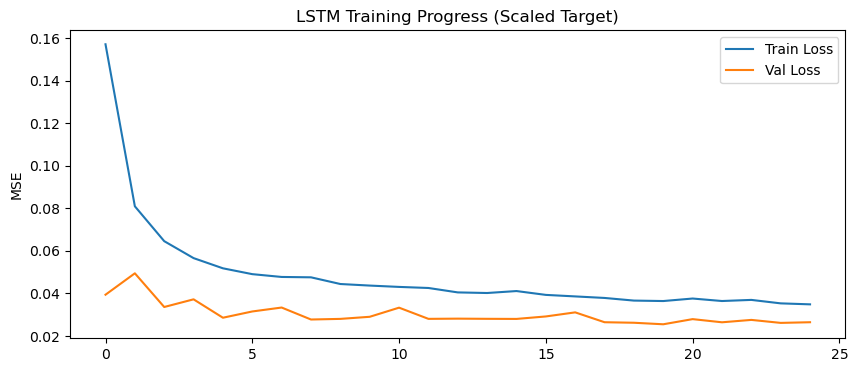

In [6]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Training Progress (Scaled Target)')
plt.ylabel('MSE')
plt.legend()
plt.show()

### 6. Probabilistic Inference

During inference, multiple stochastic forward passes $(N = 50)$ are performed to construct the predictive distribution. This yields physically interpretable RUL estimates in **operational cycles**. The resulting distribution provides two essential quantities for decision making:
- **Expected RUL** (mean prediction)
- **Uncertainty Signal** $(\sigma)$, which can be interpreted as a risk or confidence measure


In [7]:
def predict_with_uncertainty(model, X_data, n_iter=50):

    X_tensor = tf.convert_to_tensor(X_data, dtype=tf.float32)
    
    preds = []
    for i in range(n_iter):
        batch_preds = model(X_tensor, training=True) 
        preds.append(batch_preds)
        print(f"Iteration {i+1}/{n_iter} complete", end='\r')
    
    preds = np.array(preds)
    preds = np.squeeze(preds)
    
    # Calculate statistics
    preds_mean = preds.mean(axis=0) # Average prediction
    preds_std = preds.std(axis=0)   # Uncertainty
    
    print("\nMC Dropout Prediction Complete.")
    return preds_mean, preds_std

In [8]:
# Select Unit 11 for Visualization
unit_id = 11 
df_unit = val_df[val_df['unit_number'] == unit_id]

# Prepare sequences
X_unit_seq = []
y_unit_raw = [] 

if len(df_unit) > SEQUENCE_LENGTH:
    data_matrix = df_unit[feature_cols].values
    label_matrix = df_unit[['RUL']].values 
    
    for start, stop in zip(range(0, len(df_unit) - SEQUENCE_LENGTH), range(SEQUENCE_LENGTH, len(df_unit))):
        X_unit_seq.append(data_matrix[start:stop, :])
        y_unit_raw.append(label_matrix[stop-1, :])

X_unit = np.array(X_unit_seq)
y_unit_raw = np.array(y_unit_raw).flatten()

pred_mean_scaled, pred_std_scaled = predict_with_uncertainty(model, X_unit, n_iter=50)
pred_mean = pred_mean_scaled * RUL_CAP
pred_std = pred_std_scaled * RUL_CAP

Iteration 50/50 complete
MC Dropout Prediction Complete.


### 7. Visualization

- **Black dashed line**: Ground truth RUL  
- **Blue line**: Mean predicted RUL  
- **Shaded region**: $95\%$ confidence interval $(\mu \pm n\sigma)$

A widening confidence band indicates regions where the model is uncertain, typically during early healthy operation or noisy sensor regimes. As the engine approaches failure and degradation signatures become more distinct, the uncertainty band is expected to narrow. This uncertainty aware representation provides significantly richer information than deterministic regression and forms the foundation for **risk sensitive control and maintenance strategies**.


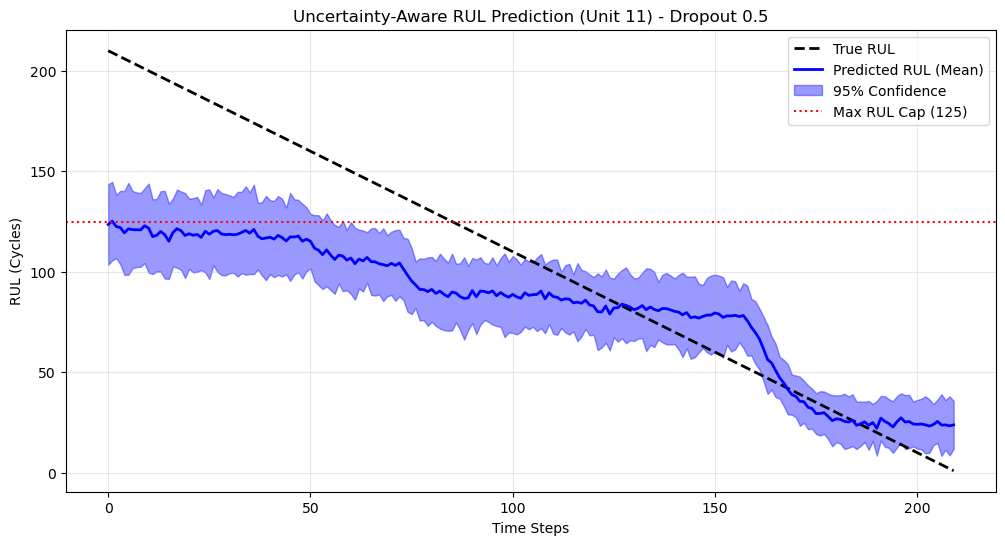

In [9]:

plt.figure(figsize=(12, 6))
plt.plot(y_unit_raw, label='True RUL', color='black', linewidth=2, linestyle='--')
plt.plot(pred_mean, label='Predicted RUL (Mean)', color='blue', linewidth=2)

plt.fill_between(
    range(len(pred_mean)), 
    pred_mean - 1.96 * pred_std, 
    pred_mean + 1.96 * pred_std, 
    color='blue', 
    alpha=0.4, 
    label='95% Confidence'
)

plt.axhline(y=RUL_CAP, color='r', linestyle=':', label='Max RUL Cap (125)')
plt.title(f'Uncertainty-Aware RUL Prediction (Unit {unit_id}) - Dropout 0.5')
plt.xlabel('Time Steps')
plt.ylabel('RUL (Cycles)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 8. Save Model in Keras Format

In [10]:
model_save_path = '../models/lstm_uncertainty_v1.keras'
model.save(model_save_path)
print(f"Model saved successfully at: {model_save_path}")

Model saved successfully at: ../models/lstm_uncertainty_v1.keras
